# Employee Attrition Prediction with LIME – End-to-End Example

This notebook is the **end-to-end demonstration** for the project’s utility layer in `lime_attrition_utils.py`.

It walks through a complete workflow:

1. Load and clean the IBM HR Employee Attrition dataset (the standard Kaggle/IBM tabular HR dataset).
2. Perform EDA to understand attrition patterns and potential drivers.
3. Engineer a small set of additional features (Feature Engineering).
4. Train and evaluate multiple non-linear models (gradient boosting and baselines) for attrition prediction.
5. Use **LIME** to produce local, human-interpretable explanations for:
   - a single high-risk employee,
   - a predicted **LEAVE** vs a predicted **STAY** example,
   - a batch of high-risk employees with aggregated “global-ish” drivers.
6. Bonus: train models on different **feature subsets** and compare how explanations for the **same employee** change.

**What you need to run this notebook**
- Place the dataset CSV in `./data/` (the notebook auto-selects the first CSV found).
- Install dependencies from `requirements.txt`.


## 0) Environment check

Quick check of Python and key library versions used in this notebook.


In [1]:
import sys, platform

import numpy as np
import pandas as pd
import sklearn

print("Python:", sys.version.split()[0])
print("Platform:", platform.system(), platform.release())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

# libraries
try:
    import lime
    print("lime:", getattr(lime, "__version__", "installed"))
except Exception as e:
    print("lime not found:", e)

for name in ["xgboost", "lightgbm"]:
    try:
        module = __import__(name)
        print(f"{name}:", getattr(module, "__version__", "installed"))
    except Exception:
        print(f"{name}: not installed")


Python: 3.10.19
Platform: Linux 6.6.87.2-microsoft-standard-WSL2
numpy: 2.2.6
pandas: 2.3.3
scikit-learn: 1.7.2
lime: installed
xgboost: 3.1.2
lightgbm: 4.6.0


## 1) Global setup, imports

In [2]:
%matplotlib inline

from pathlib import Path
import random

import matplotlib.pyplot as plt

from IPython.display import display

import lime_attrition_utils as u

# Re-import numpy and pandas here for convenience
import numpy as np
import pandas as pd

# Global random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)

print("Global random seed set to", SEED)

Global random seed set to 42


## 2) Load + clean data (via wrapper API)

We assume the IBM HR Employee Attrition CSV is available in a local `data/` directory.

All data loading and cleaning logic lives in `lime_attrition_utils.py`. In this notebook we only:
- Load the raw CSV,
- Apply dataset-specific cleaning,
- Split the cleaned table into features `X` and target `y`.

The next code cell locates the CSV in `./data`, loads it via the `lime_attrition_utils` API, cleans it, and splits it into `X` and `y`.


In [3]:
# Locate a CSV in the ./data directory
data_dir = Path("data")
csv_files = sorted(data_dir.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError("No CSV files found in ./data. Please place the IBM HR Attrition CSV there.")
csv_path = csv_files[0]
print("Using CSV:", csv_path)

# Configuration for the dataset
data_cfg = u.AttritionDataConfig()

# Load + clean via the utility API
df_raw = u.load_raw_attrition_data(str(csv_path))
df = u.clean_attrition_data(df_raw, data_cfg)

X, y = u.split_features_target(df, data_cfg)

print("Raw shape:", df_raw.shape)
print("Cleaned shape:", df.shape)
print("Number of features:", X.shape[1])

# Quick peek
display(df.head())

# Overall attrition rate (target is 0/1)
overall_attrition = float(y.mean())
print(f"Overall attrition rate: {overall_attrition:.3f} ({overall_attrition*100:.1f}%)")


Using CSV: data/WA_Fn-UseC_-HR-Employee-Attrition.csv
Raw shape: (1470, 35)
Cleaned shape: (1470, 31)
Number of features: 30


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


Overall attrition rate: 0.161 (16.1%)


### 2.1 Dataset overview (schema, types, and roles)

**Dataset**: IBM HR Employee Attrition (popular Kaggle version). Each row represents one employee record with:
- demographic attributes (e.g., `Age`, `Gender`, `MaritalStatus`)
- role/work context (e.g., `JobRole`, `Department`, `OverTime`, `BusinessTravel`)
- compensation/tenure signals (e.g., `MonthlyIncome`, `TotalWorkingYears`, `YearsAtCompany`)
- survey-like ratings (e.g., `JobSatisfaction`, `EnvironmentSatisfaction`)

**Target**: `Attrition` is converted to a binary label:
- `1` = employee left (“Leave”)
- `0` = employee stayed (“Stay”)

**How we use it**
- We drop ID / constant columns (configured in `AttritionDataConfig.id_columns`) to avoid leakage or non-informative signals.
- We treat remaining columns as features, and build a preprocessing pipeline that handles mixed numeric/categorical data.
- We evaluate with PR AUC in addition to ROC AUC because attrition is often class-imbalanced.

The next cell creates a compact schema summary table (column name, dtype, missingness, and a sample value). It is meant to make the notebook self-contained for a reader seeing the dataset for the first time.


In [4]:
# Dataset schema summary table (self-contained documentation)
schema_rows = []
for col in df.columns:
    s = df[col]
    example = None
    nn = s.dropna()
    if len(nn) > 0:
        example = nn.iloc[0]
        if isinstance(example, str) and len(example) > 40:
            example = example[:37] + "..."
    schema_rows.append(
        {
            "column": col,
            "dtype": str(s.dtype),
            "role": (
                "target"
                if col == data_cfg.target_column
                else ("dropped_id_or_constant" if col in set(getattr(data_cfg, "id_columns", []) or []) else "feature")
            ),
            "missing_%": float(s.isna().mean() * 100),
            "n_unique": int(s.nunique(dropna=True)),
            "example_value": example,
        }
    )

schema_df = pd.DataFrame(schema_rows).sort_values(["role", "column"])
display(schema_df)

# Convenience lists
feature_cols = [c for c in df.columns if c not in ([data_cfg.target_column] + (data_cfg.id_columns or []))]
cat_cols = [c for c in feature_cols if df[c].dtype == "object"]
num_cols = [c for c in feature_cols if c not in cat_cols]

print(f"Total rows: {len(df):,}")
print(f"Feature columns: {len(feature_cols)} (categorical: {len(cat_cols)}, numeric: {len(num_cols)})")


,column,dtype,role,missing_%,n_unique,example_value
0,Age,int64,feature,0.0,43,41
2,BusinessTravel,object,feature,0.0,3,Travel_Rarely
3,DailyRate,int64,feature,0.0,886,1102
4,Department,object,feature,0.0,3,Sales
5,DistanceFromHome,int64,feature,0.0,29,1
6,Education,int64,feature,0.0,5,2
7,EducationField,object,feature,0.0,6,Life Sciences
8,EnvironmentSatisfaction,int64,feature,0.0,4,2
9,Gender,object,feature,0.0,2,Female
10,HourlyRate,int64,feature,0.0,71,94


Total rows: 1,470
Feature columns: 30 (categorical: 7, numeric: 23)


## 3) EDA — attrition trends and correlations

**Goal**: Establish an intuitive baseline understanding of *who leaves* and *what attributes differ* between employees who stayed vs left.

In this section we:
- compute the overall attrition rate,
- compare attrition rates across key categorical variables (e.g., overtime, job role),
- visualize numeric distributions by attrition status,
- inspect correlations among numeric features.

Note: EDA is descriptive. It does **not** prove causality; the goal is to identify patterns worth modeling and explaining.


### 3.1 Overall attrition rate

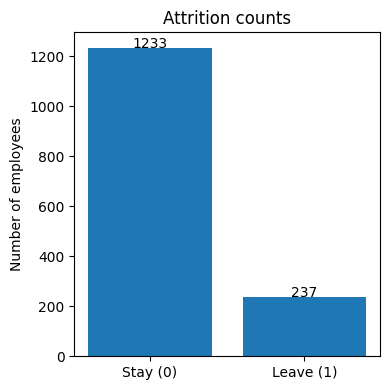

In [5]:
# Simple bar plot of attrition vs non-attrition
counts = y.value_counts().sort_index()
labels = ["Stay (0)", "Leave (1)"]
plt.figure(figsize=(4, 4))
plt.bar(labels, counts)
plt.title("Attrition counts")
plt.ylabel("Number of employees")
for i, v in enumerate(counts):
    plt.text(i, v + 1, str(v), ha="center")
plt.tight_layout()
plt.show()

### 3.2 Attrition by key categorical features

We look at attrition rates for a few important categorical features such as OverTime,
JobRole, Department, and BusinessTravel. The utility function `categorical_attrition_table`
also provides a tabular summary.


Attrition by OverTime


,n_employees,attrition_rate
OverTime,,
Yes,416,0.305288
No,1054,0.104364


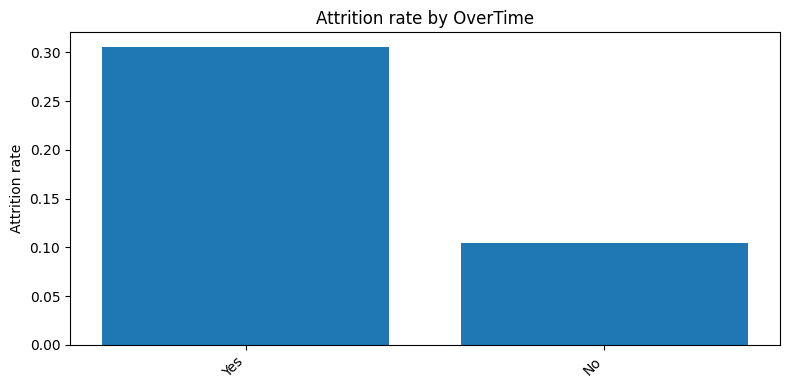

Attrition by JobRole


,n_employees,attrition_rate
JobRole,,
Sales Representative,83,0.397590
Laboratory Technician,259,0.239382
Human Resources,52,0.230769
Sales Executive,326,0.174847
Research Scientist,292,0.160959


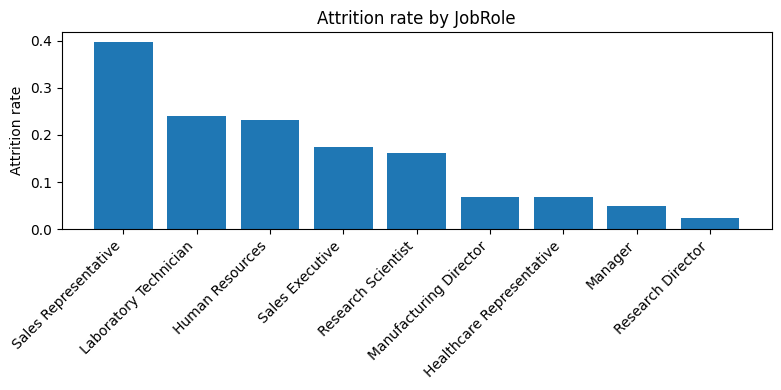

Attrition by Department


,n_employees,attrition_rate
Department,,
Sales,446,0.206278
Human Resources,63,0.190476
Research & Development,961,0.138398


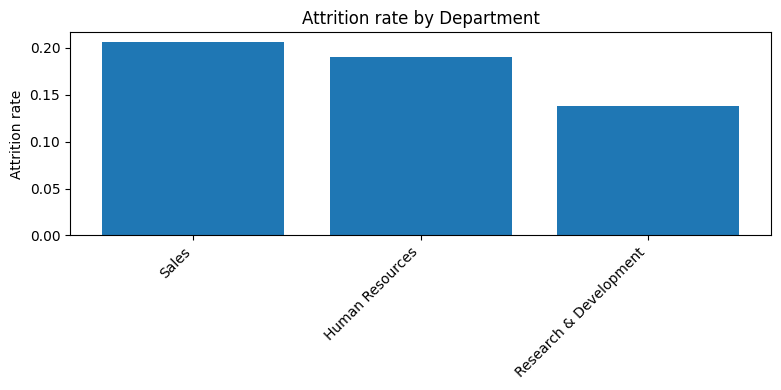

Attrition by BusinessTravel


,n_employees,attrition_rate
BusinessTravel,,
Travel_Frequently,277,0.249097
Travel_Rarely,1043,0.149569
Non-Travel,150,0.080000


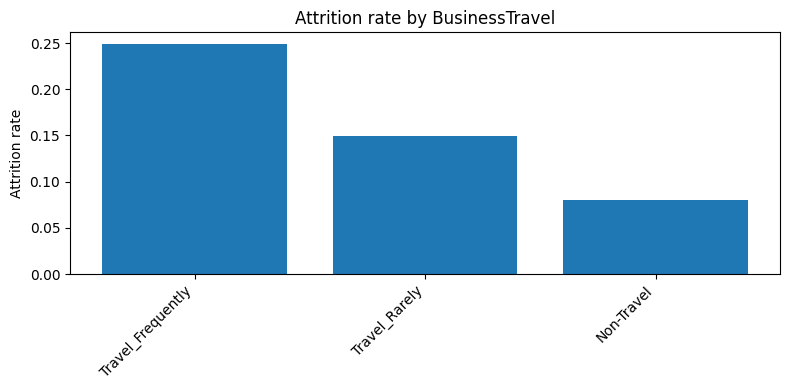

Attrition by MaritalStatus


,n_employees,attrition_rate
MaritalStatus,,
Single,470,0.255319
Married,673,0.124814
Divorced,327,0.100917


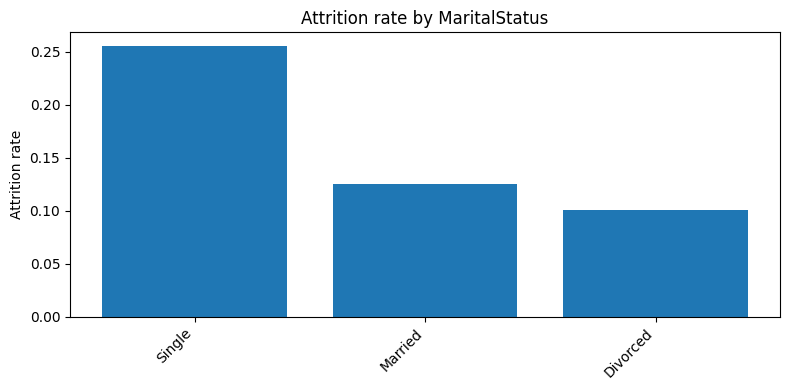

In [6]:
def plot_attrition_rate_by_cat(df: pd.DataFrame, column: str, cfg: u.AttritionDataConfig):
    """Bar plot of attrition rate by category."""
    tbl = u.categorical_attrition_table(df, column, cfg)
    display(tbl.head())
    plt.figure(figsize=(8, 4))
    plt.bar(tbl.index.astype(str), tbl["attrition_rate"])
    plt.title(f"Attrition rate by {column}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Attrition rate")
    plt.tight_layout()
    plt.show()

for col in ["OverTime", "JobRole", "Department", "BusinessTravel", "MaritalStatus"]:
    if col in df.columns:
        print(f"Attrition by {col}")
        plot_attrition_rate_by_cat(df, col, data_cfg)


### 3.3 Numeric distributions by attrition

For numeric features, we compare distributions for employees who stayed vs those who left.


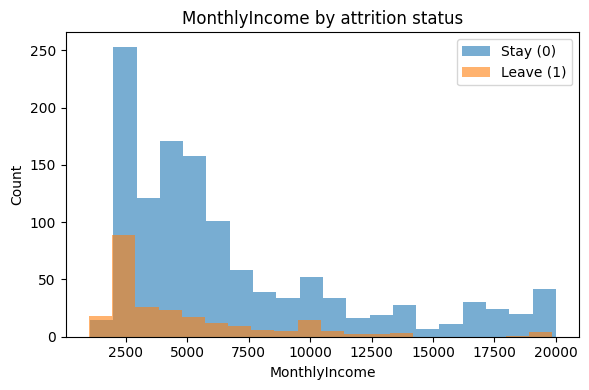

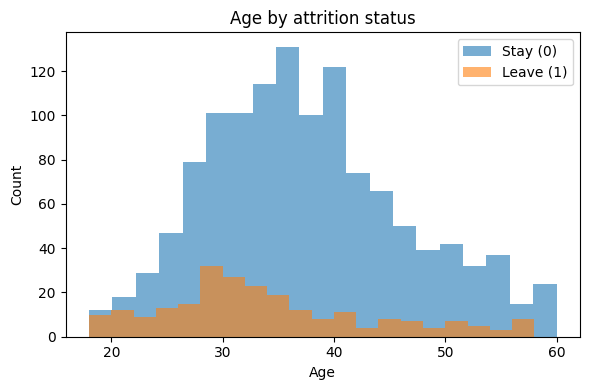

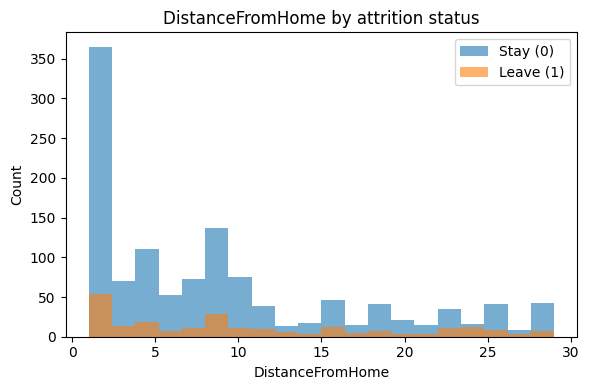

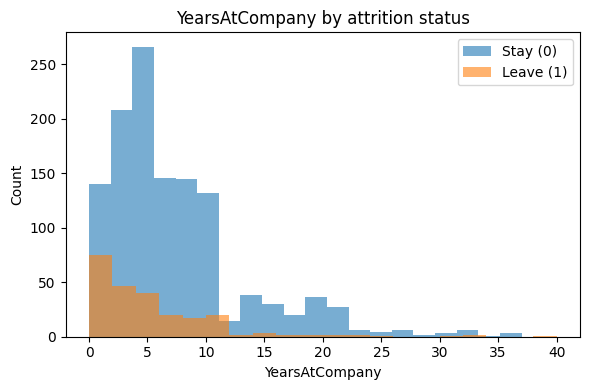

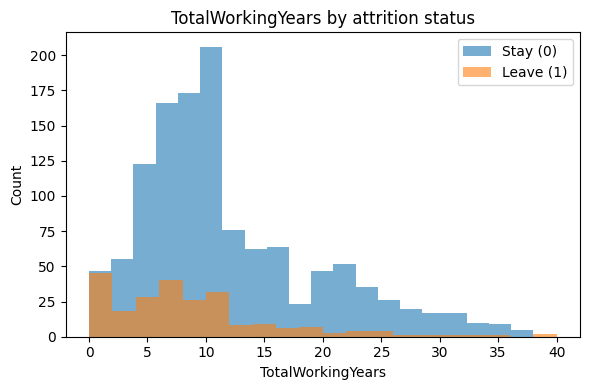

In [7]:
def plot_num_by_attrition(df: pd.DataFrame, column: str, cfg: u.AttritionDataConfig):
    """Histogram by attrition status for a numeric column."""
    if column not in df.columns:
        print(f"Column {column} not in DataFrame; skipping.")
        return

    plt.figure(figsize=(6, 4))
    for attr_value, color, label in [(0, "C0", "Stay (0)"), (1, "C1", "Leave (1)")]:
        subset = df[df[cfg.target_column] == attr_value][column]
        plt.hist(subset, bins=20, alpha=0.6, label=label)
    plt.title(f"{column} by attrition status")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

for col in ["MonthlyIncome", "Age", "DistanceFromHome", "YearsAtCompany", "TotalWorkingYears"]:
    if col in df.columns:
        plot_num_by_attrition(df, col, data_cfg)


### 3.4 Correlation of numeric features with attrition

In [8]:
# Simple correlation of numeric features with the 0/1 attrition target
num_cols = df.select_dtypes(include=["number"]).columns
num_df = df[num_cols].copy()
num_df["AttritionTarget"] = y.values

corr = (
    num_df.corr()["AttritionTarget"]
    .drop("AttritionTarget")
    .sort_values(key=lambda s: s.abs(), ascending=False)
)
corr.head(15)

Attrition                  1.000000
TotalWorkingYears         -0.171063
JobLevel                  -0.169105
YearsInCurrentRole        -0.160545
MonthlyIncome             -0.159840
Age                       -0.159205
YearsWithCurrManager      -0.156199
StockOptionLevel          -0.137145
YearsAtCompany            -0.134392
JobInvolvement            -0.130016
JobSatisfaction           -0.103481
EnvironmentSatisfaction   -0.103369
DistanceFromHome           0.077924
WorkLifeBalance           -0.063939
TrainingTimesLastYear     -0.059478
Name: AttritionTarget, dtype: float64

### 3.5 Correlation heatmap

A correlation heatmap helps spot strong linear relationships among numeric variables including the target. This can reveal redundancy and potential proxies.


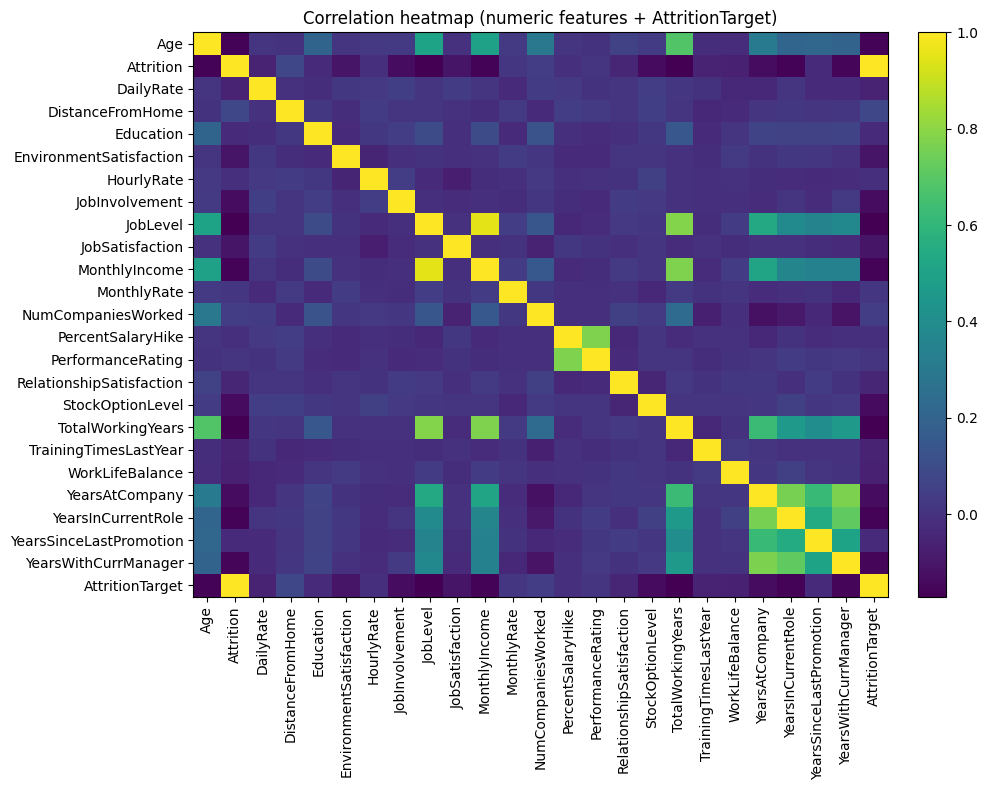

In [9]:
# Correlation heatmap for numeric features (including the attrition target)
corr_matrix = num_df.corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Correlation heatmap (numeric features + AttritionTarget)")
plt.tight_layout()
plt.show()

## 4) Feature engineering

Feature engineering is where we translate domain intuition into additional signals. Below we add a few illustrative features (ratios/buckets) that often make sense in HR contexts (e.g., income normalized by tenure).

Important: all feature engineering is applied **before** train/test split here for simplicity, but it is purely deterministic.


In [10]:
def add_engineered_features(X_in: pd.DataFrame) -> pd.DataFrame:
    X2 = X_in.copy()

    if {"MonthlyIncome", "YearsAtCompany"}.issubset(X2.columns):
        X2["IncomePerYearAtCompany"] = X2["MonthlyIncome"] / (X2["YearsAtCompany"] + 1)

    if {"YearsAtCompany", "TotalWorkingYears"}.issubset(X2.columns):
        X2["TenureRatio"] = X2["YearsAtCompany"] / (X2["TotalWorkingYears"] + 1)

    if "DistanceFromHome" in X2.columns:
        X2["LongCommute"] = (X2["DistanceFromHome"] >= 10).astype(int)

    if "Age" in X2.columns:
        X2["EarlyCareer"] = (X2["Age"] <= 30).astype(int)

    return X2

X_fe = add_engineered_features(X)

print("Original #features:", X.shape[1])
print("After FE #features:", X_fe.shape[1])

new_cols = [c for c in X_fe.columns if c not in X.columns]
print("Engineered features added:", new_cols)


Original #features: 30
After FE #features: 34
Engineered features added: ['IncomePerYearAtCompany', 'TenureRatio', 'LongCommute', 'EarlyCareer']


## 5) Split + preprocess + model training (gradient boosting models)

Next we:

1. Split into train/test using `train_test_split_attrition` (with a fixed `random_state` for reproducibility).
2. Build a preprocessing pipeline with `build_preprocessor` **fit on train only** to avoid leakage.
3. Train a set of non-linear models (XGBoost / LightGBM / RandomForest).
4. Evaluate each model with multiple metrics.

**Why PR AUC?** Attrition prediction is commonly imbalanced (fewer “Leave” rows). PR AUC (Average Precision) emphasizes performance on the positive class and is often more informative than accuracy.


In [11]:
# Train/test split on the engineered features
X_train, X_test, y_train, y_test = u.train_test_split_attrition(X_fe, y, data_cfg)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Build preprocessor
pre = u.build_preprocessor(X_train)

# Configure models: try to train all supported boosters + RF
model_cfg = u.ModelConfig(
    use_xgboost=True,
    use_lightgbm=True,
    use_random_forest=True,
)

import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names"
)


# Train models via the utils API
models = u.train_attrition_models(X_train, y_train, pre, model_cfg)

# Evaluate
metrics = u.evaluate_models(models, X_test, y_test)

metrics_df = (
    pd.DataFrame(metrics)
    .T
    .sort_values(["pr_auc", "roc_auc"], ascending=[False, False])
)
display(metrics_df)

# Choose the best model by PR AUC (fallback to ROC AUC if needed)
metric_key = "pr_auc"
if metric_key not in metrics_df.columns:
    metric_key = "roc_auc"

best_model_name = metrics_df[metric_key].idxmax()
best_pipe = models[best_model_name]

print(f"Best model by {metric_key}: {best_model_name}")


Train shape: (1176, 34)
Test shape: (294, 34)


,accuracy,precision,recall,f1,roc_auc,pr_auc
xgboost,0.857143,0.692308,0.191489,0.300000,0.791024,0.514076
gradient_boosting,0.846939,0.562500,0.191489,0.285714,0.801275,0.472948
lightgbm,0.860544,0.714286,0.212766,0.327869,0.770954,0.456022
random_forest,0.846939,0.625000,0.106383,0.181818,0.793781,0.440558


Best model by pr_auc: xgboost


### 5.1 Evaluation curves for the best model

We now visualize the **ROC curve** and **Precision–Recall curve** for the
best-performing model selected above.

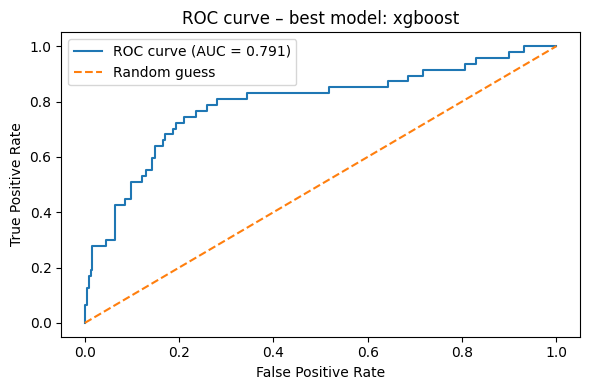

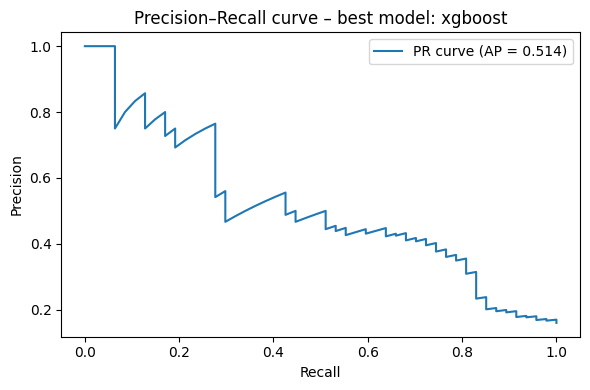

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Predict probabilities for the positive class on the test set
y_proba_best = best_pipe.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve – best model: {best_model_name}")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall curve
precisions, recalls, _ = precision_recall_curve(y_test, y_proba_best)
ap = average_precision_score(y_test, y_proba_best)

plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall curve – best model: {best_model_name}")
plt.legend()
plt.tight_layout()
plt.show()

### 5.2 Error analysis (confusion matrix, thresholding, and example failures)

AUC-style metrics summarize ranking quality, but HR decisions are made using a **threshold** (e.g., flag the top-risk employees).
Here we:

- compute confusion matrices at:
  - the default threshold **0.50**, and
  - a threshold that maximizes **F1** on the test set.
- inspect a few false positives / false negatives to understand typical failure modes.

This also sets up later LIME explanations for *mistakes*, which is a useful way to stress-test interpretability.


Confusion matrix (threshold = 0.50)
Threshold = 0.500
              precision    recall  f1-score   support

           0      0.865     0.984     0.920       247
           1      0.692     0.191     0.300        47

    accuracy                          0.857       294
   macro avg      0.779     0.588     0.610       294
weighted avg      0.837     0.857     0.821       294



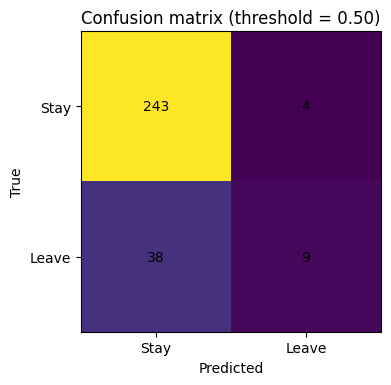

Confusion matrix (threshold = best F1)
Threshold = 0.155
              precision    recall  f1-score   support

           0      0.932     0.830     0.878       247
           1      0.432     0.681     0.529        47

    accuracy                          0.806       294
   macro avg      0.682     0.755     0.703       294
weighted avg      0.852     0.806     0.822       294



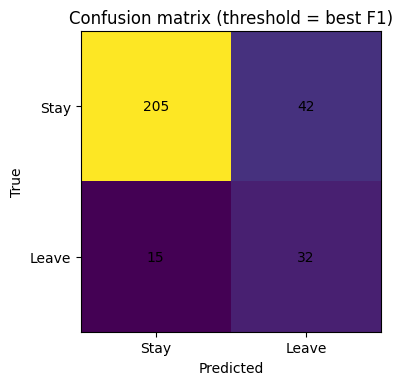

False positives @0.50: 4
False negatives @0.50: 38


,y_true,y_proba_leave
301,0,0.875164
1402,0,0.725877
764,0,0.673728
1391,0,0.501572


,y_true,y_proba_leave
1111,1,0.006038
45,1,0.008563
789,1,0.011594
217,1,0.014037
24,1,0.023494


In [13]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# Use the probability outputs already computed for the best model
try:
    y_proba = y_proba_best
except NameError:
    y_proba = best_pipe.predict_proba(X_test)[:, 1]

def show_confusion(y_true, y_prob, threshold: float, title: str):
    y_hat = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    print(title)
    print(f"Threshold = {threshold:.3f}")
    print(classification_report(y_true, y_hat, digits=3))
    plt.figure(figsize=(4, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0, 1], ["Stay", "Leave"])
    plt.yticks([0, 1], ["Stay", "Leave"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for (r, c), v in np.ndenumerate(cm):
        plt.text(c, r, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()
    return y_hat, cm

# 1) Default threshold
y_hat_05, cm_05 = show_confusion(y_test, y_proba, threshold=0.50, title="Confusion matrix (threshold = 0.50)")

# 2) Threshold chosen to maximize F1 on test set (illustrative; for real deployment use a validation set)
prec, rec, thr = precision_recall_curve(y_test, y_proba)
# precision_recall_curve returns thresholds of length n-1
f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_i = int(np.nanargmax(f1))
best_thr = float(thr[best_i])

y_hat_f1, cm_f1 = show_confusion(y_test, y_proba, threshold=best_thr, title="Confusion matrix (threshold = best F1)")

# Collect a small error table for inspection
err_df = X_test.copy()
err_df["y_true"] = y_test.values
err_df["y_proba_leave"] = y_proba
err_df["y_pred_05"] = y_hat_05
err_df["is_error_05"] = (err_df["y_true"] != err_df["y_pred_05"]).astype(int)

fp = err_df[(err_df["y_true"] == 0) & (err_df["y_pred_05"] == 1)].sort_values("y_proba_leave", ascending=False)
fn = err_df[(err_df["y_true"] == 1) & (err_df["y_pred_05"] == 0)].sort_values("y_proba_leave", ascending=True)

print(f"False positives @0.50: {len(fp)}")
print(f"False negatives @0.50: {len(fn)}")

# Save one example index of each type for later LIME
fp_idx = int(fp.index[0]) if len(fp) > 0 else None
fn_idx = int(fn.index[0]) if len(fn) > 0 else None

display(fp[["y_true","y_proba_leave"]].head(5))
display(fn[["y_true","y_proba_leave"]].head(5))


## 6) LIME explanations (single employee + batch + aggregated drivers)

We now use LIME to understand **why** the model predicts some employees are
at higher risk of attrition.

We start by explaining the single **highest-risk** employee according to the
best model's predicted probability of leaving.


The following cells select a high-risk employee, build a LIME explainer from the trained pipeline, and inspect both individual and aggregated explanations.

Index of highest-risk test employee: 200, predicted P(leave) = 0.986
Top LIME features for the highest-risk employee:
cat__OverTime_No <= 0.00: 0.143
num__JobInvolvement <= -1.05: 0.111
num__StockOptionLevel <= -0.94: 0.102
num__MonthlyIncome <= -0.77: 0.090
num__DistanceFromHome > 0.57: 0.079
cat__BusinessTravel_Travel_Frequently <= 0.00: -0.074
num__NumCompaniesWorked <= -0.68: -0.073
num__Age <= -0.76: 0.065
0.26 < num__EnvironmentSatisfaction <= 1.18: -0.061
num__JobSatisfaction <= -0.65: 0.057


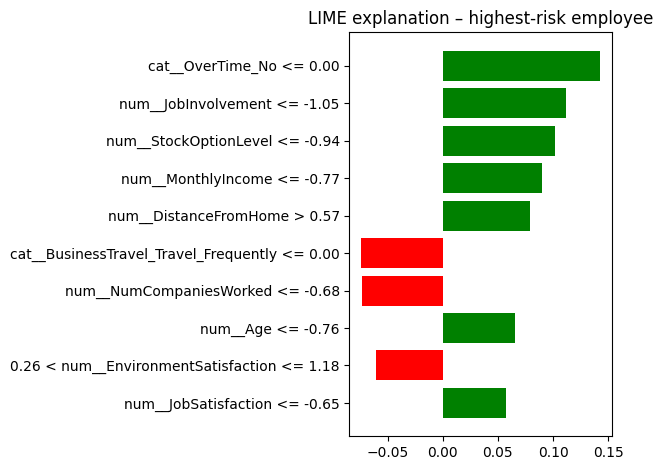

Saved HTML explanation to artifacts/lime_explanation_toprisk.html


In [14]:
# Predict probabilities of leaving for the test set
probs = best_pipe.predict_proba(X_test)[:, 1]
top_idx = int(np.argmax(probs))
top_prob = float(probs[top_idx])

print(f"Index of highest-risk test employee: {top_idx}, predicted P(leave) = {top_prob:.3f}")

row = X_test.iloc[top_idx]

# Build LIME explainer using the fitted preprocessor from the pipeline
pre_fitted = best_pipe.named_steps["preprocess"]
explainer = u.build_lime_explainer(
    preprocessor=pre_fitted,
    X_train=X_train,
    class_names=["Stay", "Leave"],
)

# LIME configuration
lcfg = u.LimeConfig(num_features=10, num_samples=5000)

# Explain this single high-risk employee
exp = u.explain_single_employee(
    explainer=explainer,
    model_pipeline=best_pipe,
    raw_row=row,
    preprocessor=pre_fitted,
    lime_config=lcfg,
)

print("Top LIME features for the highest-risk employee:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.3f}")

# Plot the explanation
fig = exp.as_pyplot_figure()
plt.title("LIME explanation – highest-risk employee")
plt.tight_layout()
plt.show()

# Optionally save as HTML artifact
try:
    exp.save_to_file("artifacts/lime_explanation_toprisk.html")
    print("Saved HTML explanation to artifacts/lime_explanation_toprisk.html")
except Exception as e:
    print("Could not save HTML explanation:", e)


### 6.1 Compare one predicted LEAVE vs one predicted STAY example

To complement the single highest-risk employee, we also inspect:

- one employee the model predicts will **leave** (prediction = 1), and  
- one employee the model predicts will **stay** (prediction = 0),  

and compare their LIME explanations side by side.


Example index predicted to LEAVE: 35
Example index predicted to STAY: 0
LIME explanation for LEAVE example:
cat__OverTime_No <= 0.00: 0.131
num__StockOptionLevel <= -0.94: 0.107
num__EnvironmentSatisfaction <= -0.66: 0.106
-1.05 < num__JobInvolvement <= 0.37: -0.081
num__NumCompaniesWorked <= -0.68: -0.077
cat__BusinessTravel_Travel_Frequently > 0.00: 0.074
-1.06 < num__WorkLifeBalance <= 0.34: -0.067
num__JobSatisfaction <= -0.65: 0.057
cat__BusinessTravel_Non-Travel <= 0.00: 0.057
num__RelationshipSatisfaction <= -0.68: 0.054

LIME explanation for STAY example:
0.00 < cat__OverTime_No <= 1.00: -0.140
num__MonthlyIncome <= -0.77: 0.087
-1.05 < num__JobInvolvement <= 0.37: -0.082
num__NumCompaniesWorked <= -0.68: -0.082
-0.94 < num__StockOptionLevel <= 0.25: -0.073
cat__BusinessTravel_Travel_Frequently <= 0.00: -0.073
num__Age <= -0.76: 0.066
-1.06 < num__WorkLifeBalance <= 0.34: -0.065
num__YearsWithCurrManager <= -0.62: 0.058
num__JobSatisfaction <= -0.65: 0.058


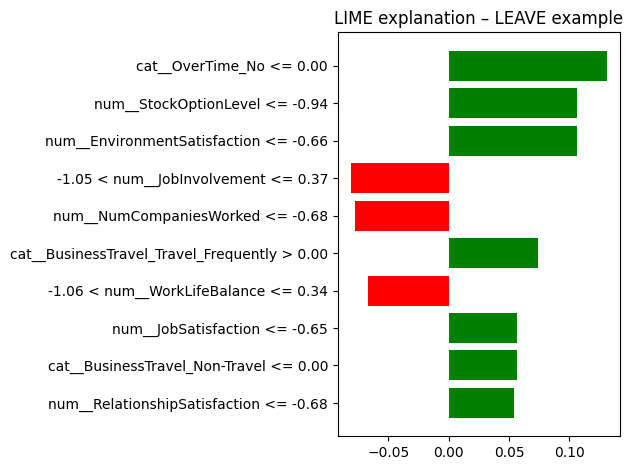

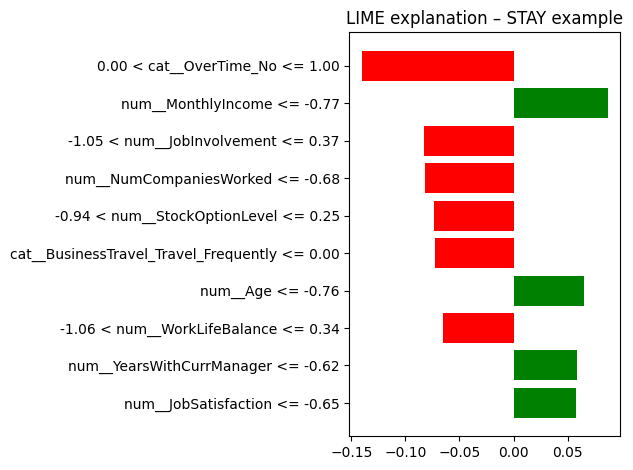

In [15]:
# Get hard predictions on the test set
y_pred = best_pipe.predict(X_test)

# Indices for examples
leave_indices = np.where(y_pred == 1)[0]
stay_indices = np.where(y_pred == 0)[0]

if len(leave_indices) == 0 or len(stay_indices) == 0:
    print("Model did not produce both classes on the test set; skipping LEAVE/STAY comparison.")
else:
    leave_idx = int(leave_indices[0])
    stay_idx = int(stay_indices[0])

    print("Example index predicted to LEAVE:", leave_idx)
    print("Example index predicted to STAY:", stay_idx)

    row_leave = X_test.iloc[leave_idx]
    row_stay = X_test.iloc[stay_idx]

    # LIME explanations using the wrapper API
    exp_leave = u.explain_single_employee(
        explainer=explainer,
        model_pipeline=best_pipe,
        raw_row=row_leave,
        preprocessor=pre_fitted,
        lime_config=lcfg,
    )

    exp_stay = u.explain_single_employee(
        explainer=explainer,
        model_pipeline=best_pipe,
        raw_row=row_stay,
        preprocessor=pre_fitted,
        lime_config=lcfg,
    )

    # Text view of explanations
    print("LIME explanation for LEAVE example:")
    for feature, weight in exp_leave.as_list():
        print(f"{feature}: {weight:.3f}")

    print("\nLIME explanation for STAY example:")
    for feature, weight in exp_stay.as_list():
        print(f"{feature}: {weight:.3f}")

    # Visualize with native LIME plots
    fig = exp_leave.as_pyplot_figure()
    plt.title("LIME explanation – LEAVE example")
    plt.tight_layout()
    plt.show()

    fig = exp_stay.as_pyplot_figure()
    plt.title("LIME explanation – STAY example")
    plt.tight_layout()
    plt.show()


### 6.1b Error Analysis for LIME

Explaining correct predictions is useful, but explaining **mistakes** is often more informative:
- For a **false positive** (predicted Leave, actually Stay), LIME can reveal which factors “pushed” risk upward.
- For a **false negative** (predicted Stay, actually Leave), LIME can show what the model *missed* or underweighted.

Below we generate LIME explanations for one FP and one FN (if they exist at the default 0.50 threshold).


False Positive – index=301, P(leave)=0.875
0.00 < cat__OverTime_No <= 1.00: -0.128
num__JobInvolvement <= -1.05: 0.109
num__StockOptionLevel <= -0.94: 0.092
num__MonthlyIncome <= -0.77: 0.089
num__NumCompaniesWorked <= -0.68: -0.078
cat__BusinessTravel_Travel_Frequently <= 0.00: -0.072
num__Age <= -0.76: 0.071
-1.06 < num__WorkLifeBalance <= 0.34: -0.068
cat__BusinessTravel_Non-Travel <= 0.00: 0.065
0.26 < num__EnvironmentSatisfaction <= 1.18: -0.059


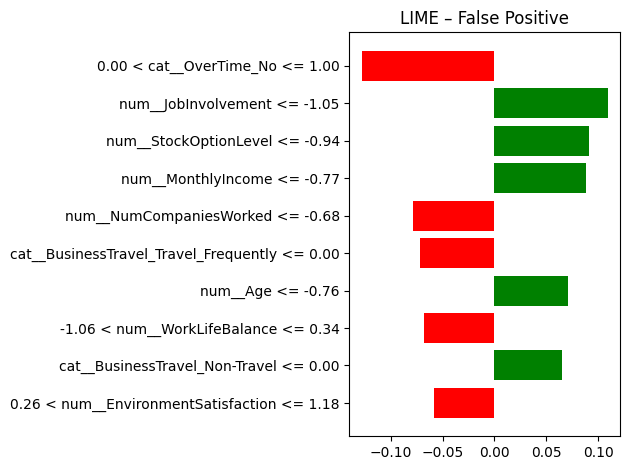

Saved: artifacts/lime_false_positive.html
False Negative – index=1111, P(leave)=0.006
0.00 < cat__OverTime_No <= 1.00: -0.125
num__JobInvolvement <= -1.05: 0.110
cat__BusinessTravel_Travel_Frequently <= 0.00: -0.077
num__NumCompaniesWorked <= -0.68: -0.074
-1.06 < num__WorkLifeBalance <= 0.34: -0.068
-0.94 < num__StockOptionLevel <= 0.25: -0.067
cat__BusinessTravel_Non-Travel <= 0.00: 0.066
num__DistanceFromHome <= -0.90: -0.062
num__RelationshipSatisfaction <= -0.68: 0.060
0.25 < num__JobSatisfaction <= 1.15: -0.060


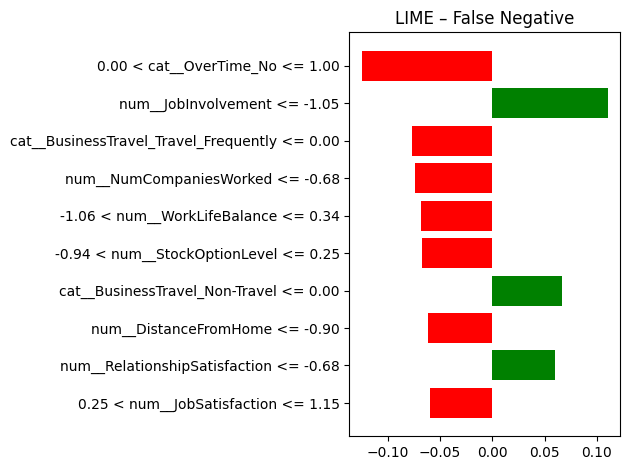

Saved: artifacts/lime_false_negative.html


In [16]:
# LIME explanations for one false-positive and one false-negative (if available)
from pathlib import Path

artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

pre_fitted = best_pipe.named_steps["preprocess"]
explainer = u.build_lime_explainer(
    preprocessor=pre_fitted,
    X_train=X_train,
    class_names=["Stay", "Leave"],
)

# LIME configuration (increase num_samples for more stable explanations)
lcfg = u.LimeConfig(num_features=10, num_samples=5000)

def explain_by_index(row_index, title_prefix):
    if row_index is None:
        print(f"No {title_prefix} example available; skipping.")
        return
    if row_index not in X_test.index:
        print(f"{title_prefix} index {row_index} not in X_test index; skipping.")
        return

    raw_row = X_test.loc[row_index]
    exp = u.explain_single_employee(
        explainer=explainer,
        model_pipeline=best_pipe,
        raw_row=raw_row,
        preprocessor=pre_fitted,
        lime_config=lcfg,
    )

    proba = float(best_pipe.predict_proba(pd.DataFrame([raw_row]))[0, 1])
    print(f"{title_prefix} – index={row_index}, P(leave)={proba:.3f}")
    for feat, w in exp.as_list():
        print(f"{feat}: {w:.3f}")

    fig = exp.as_pyplot_figure()
    plt.title(f"LIME – {title_prefix}")
    plt.tight_layout()
    plt.show()

    # Save as HTML for report reuse
    out_path = artifacts_dir / f"lime_{title_prefix.replace(' ', '_').lower()}.html"
    try:
        exp.save_to_file(str(out_path))
        print("Saved:", out_path)
    except Exception as e:
        print("Could not save HTML explanation:", e)

# fp_idx and fn_idx are set in the error analysis section (if run)
try:
    explain_by_index(fp_idx, "False Positive")
    explain_by_index(fn_idx, "False Negative")
except NameError:
    print("Run the error analysis.")



### 6.2 Batch LIME explanations and aggregated drivers

We now generate explanations for a *batch* of high-risk employees and aggregate
those explanations into a global-ish view of which factors most often push
predictions toward attrition.


,rank,row_index,predicted_leave_prob,top_factors,actual_attrition
0,1,688,0.986189,cat__OverTime_No <= 0.00 (+0.13); num__JobInvo...,1
1,2,911,0.981625,cat__OverTime_No <= 0.00 (+0.13); num__JobInvo...,1
2,3,357,0.911347,cat__OverTime_No <= 0.00 (+0.13); num__JobInvo...,1
3,4,301,0.875164,0.00 < cat__OverTime_No <= 1.00 (-0.14); num__...,0
4,5,711,0.861368,cat__OverTime_No <= 0.00 (+0.12); num__NumComp...,1


Saved top-risk LIME summary to artifacts/top_risk_employees_lime.csv
Long-form LIME table shape: (250, 8)


,row_index,feature,feature_hr,weight,abs_weight,direction,predicted_leave_prob,actual_attrition
0,688,cat__OverTime_No <= 0.00,OverTime ≠ No,0.131555,0.131555,push_leave,0.986189,1
1,688,num__JobInvolvement <= -1.05,JobInvolvement is low,0.115734,0.115734,push_leave,0.986189,1
2,688,num__MonthlyIncome <= -0.77,MonthlyIncome is low,0.098280,0.098280,push_leave,0.986189,1
3,688,num__StockOptionLevel <= -0.94,StockOptionLevel is low,0.091893,0.091893,push_leave,0.986189,1
4,688,num__DistanceFromHome > 0.57,DistanceFromHome is high,0.085443,0.085443,push_leave,0.986189,1


,feature,count,mean_weight,mean_abs_weight,pct_push_leave
0,OverTime ≠ No,16,0.131428,0.131428,1.0
1,0.00 < cat__OverTime_No <= 1.00,9,-0.129890,0.129890,0.0
2,NumCompaniesWorked is high,8,0.116325,0.116325,1.0
3,JobInvolvement is low,14,0.115526,0.115526,1.0
4,EnvironmentSatisfaction is low,11,0.097919,0.097919,1.0
5,StockOptionLevel is low,20,0.095118,0.095118,1.0
6,MonthlyIncome is low,15,0.086970,0.086970,1.0
7,WorkLifeBalance is low,5,0.085906,0.085906,1.0
8,-1.05 < num__JobInvolvement <= 0.37,10,-0.083376,0.083376,0.0
9,DistanceFromHome is high,7,0.076633,0.076633,1.0


Saved aggregate LIME drivers to artifacts/lime_aggregate_drivers.csv


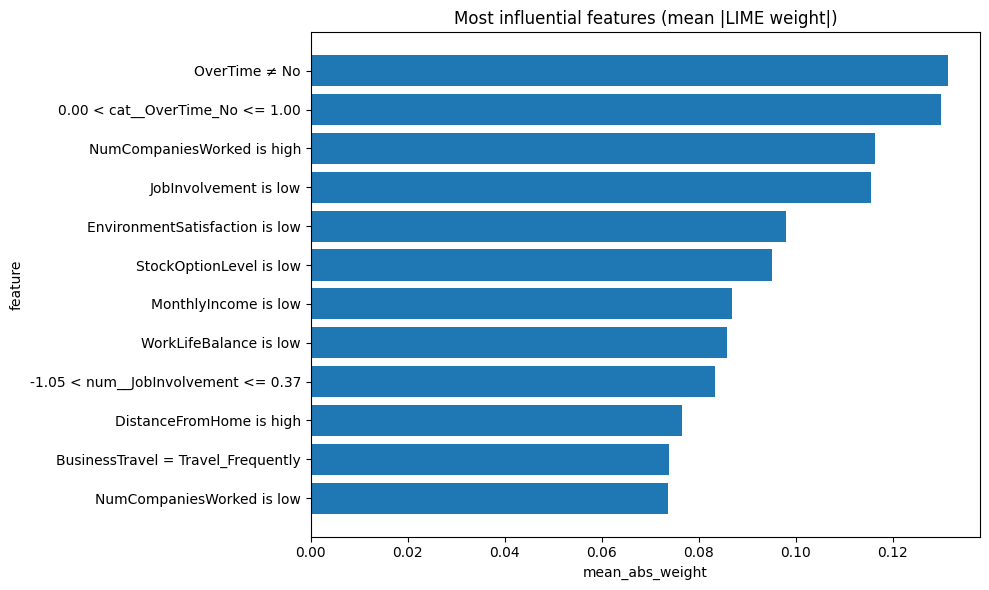

In [17]:
# Batch explanations for the top-N highest-risk employees
top_n_batch = 25

batch_df = u.batch_lime_explanations(
    explainer=explainer,
    model_pipeline=best_pipe,
    X=X_test,
    y=y_test,
    preprocessor=pre_fitted,
    lime_config=lcfg,
    top_n=top_n_batch,
    top_k_features=5,
)

display(batch_df.head())

# Save a CSV artifact
batch_df.to_csv("artifacts/top_risk_employees_lime.csv", index=False)
print("Saved top-risk LIME summary to artifacts/top_risk_employees_lime.csv")

# Long-form LIME weights
long_df = u.batch_lime_explanations_long(
    explainer=explainer,
    model_pipeline=best_pipe,
    X=X_test,
    y=y_test,
    preprocessor=pre_fitted,
    lime_config=lcfg,
    top_n=top_n_batch,
    top_k_features=10,
)

print("Long-form LIME table shape:", long_df.shape)
display(long_df.head())

# Aggregate into a global-ish feature importance view
agg_df = u.aggregate_lime_features(long_df)

# Ensure we have a 'feature' column for plotting convenience
if "feature" not in agg_df.columns and "feature_hr" in agg_df.columns:
    agg_df = agg_df.rename(columns={"feature_hr": "feature"})

display(agg_df.sort_values("mean_abs_weight", ascending=False).head(15))

# Save aggregate drivers
agg_df.to_csv("artifacts/lime_aggregate_drivers.csv", index=False)
print("Saved aggregate LIME drivers to artifacts/lime_aggregate_drivers.csv")

# Plot the most influential features by mean absolute weight
try:
    fig = u.plot_lime_aggregate_bar(
        agg_df,
        top_n=12,
        sort_by="mean_abs_weight",
        title="Most influential features (mean |LIME weight|)",
    )
    plt.show()
except Exception as e:
    print("Could not plot aggregate LIME bar chart:", e)


## 7) Bonus — Feature Subset Experiments: How Explanations Change

A key question with local explainers is **stability**: do we tell a consistent story if we slightly change the feature set?

For the **bonus**, we train the model on different **feature subsets** and compare how the explanations for the **same employee** change.

We define:
- a full "All + engineered features" model (reference set),
- a "Demographics" subset,
- a "Workload & work-life" subset,
- a "Compensation & tenure" subset.

For each subset-model we compute the **Jaccard similarity** between the *top-10* LIME features and the reference model’s *top-10* features.
Higher similarity suggests explanations are more stable under that feature-selection change.


In [18]:
# Helper: extract a stable "feature key" from a LIME feature string
def lime_feature_key(s: str) -> str:
    """
    Convert a LIME feature description into a stable key, e.g.
    "0.00 < cat__OverTime_No <= 1.00" -> "cat__OverTime_No"
    "num__MonthlyIncome <= -0.77"    -> "num__MonthlyIncome"
    """
    s2 = s.strip()
    if " < " in s2:
        s2 = s2.split(" < ", 1)[1].strip()
    for op in [" <= ", " >= ", " < ", " > "]:
        if op in s2:
            s2 = s2.split(op, 1)[0].strip()
    return s2

def top_k_keys(exp_obj, k: int = 10):
    """
    Take the top-k LIME features and return de-duplicated stable keys.
    """
    pairs = exp_obj.as_list()
    keys = [lime_feature_key(name) for name, _ in pairs[:k]]
    seen = set()
    out = []
    for x in keys:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

# Reference keys from the full model explanation of the high-risk employee
ref_keys = top_k_keys(exp, k=10)
ref_keys

['cat__OverTime_No',
 'num__JobInvolvement',
 'num__StockOptionLevel',
 'num__MonthlyIncome',
 'num__DistanceFromHome',
 'cat__BusinessTravel_Travel_Frequently',
 'num__NumCompaniesWorked',
 'num__Age',
 'num__EnvironmentSatisfaction',
 'num__JobSatisfaction']

In [19]:
# Define feature subsets
all_cols = list(X_fe.columns)

def cols_if_present(candidates):
    return [c for c in candidates if c in all_cols]

subset_defs = {
    # Reference: all original + engineered features
    "All+FE (reference)": all_cols,

    # Demographic-focused subset
    "Demographics only": cols_if_present([
        "Age",
        "Gender",
        "Education",
        "EducationField",
        "MaritalStatus",
        "EnvironmentSatisfaction",
        "JobSatisfaction",
        "RelationshipSatisfaction",
    ]),

    # Workload & work-life focused subset
    "Workload & work-life": cols_if_present([
        "OverTime",
        "BusinessTravel",
        "JobInvolvement",
        "WorkLifeBalance",
        "JobLevel",
        "JobRole",
        "Department",
        "DistanceFromHome",
        "YearsInCurrentRole",
        "YearsWithCurrManager",
        "LongCommute",     # engineered
        "EarlyCareer",     # engineered
    ]),

    # Compensation & tenure focused subset
    "Compensation & tenure": cols_if_present([
        "MonthlyIncome",
        "PercentSalaryHike",
        "StockOptionLevel",
        "TotalWorkingYears",
        "YearsAtCompany",
        "YearsSinceLastPromotion",
        "IncomePerYearAtCompany",  # engineered
        "TenureRatio",             # engineered
    ]),
}
subset_defs = {
    name: cols for name, cols in subset_defs.items()
    if len(cols) >= 5
}

subset_defs.keys()

dict_keys(['All+FE (reference)', 'Demographics only', 'Workload & work-life', 'Compensation & tenure'])

In [20]:
from typing import List, Dict, Any

def train_subset_model(
    best_model_name: str,
    subset_cols: List[str],
    metric_key: str = "pr_auc",
) -> tuple[Any, Any, str, Dict[str, float]]:
    """Train a model on a given subset of columns.

    We prefer to reuse the same model family as the original best model,
    if possible. Otherwise we fall back to gradient boosting.

    Returns:
        chosen_pipe: trained Pipeline for this subset
        pre_fitted:  fitted preprocessor (pipeline.named_steps["preprocess"])
        chosen_name: name of the chosen model
        chosen_metrics: metrics dict for the chosen model
    """
    # Restrict training / test data to the subset columns
    Xtr = X_train[subset_cols]
    Xte = X_test[subset_cols]

    # Build a fresh preprocessor for this subset (unfitted)
    pre_sub = u.build_preprocessor(Xtr)

    # Configure model toggles based on best_model_name
    cfg_sub = u.ModelConfig(
        use_xgboost=(best_model_name == "xgboost"),
        use_lightgbm=(best_model_name == "lightgbm"),
        use_random_forest=(best_model_name == "random_forest"),
    )

    # Train models on this subset using the unfitted preprocessor
    models_sub = u.train_attrition_models(Xtr, y_train, pre_sub, cfg_sub)
    metrics_sub = u.evaluate_models(models_sub, Xte, y_test)

    # Choose candidate: same type if present, else gradient boosting
    if best_model_name in metrics_sub:
        chosen_name = best_model_name
    else:
        chosen_name = "gradient_boosting"

    chosen_pipe = models_sub[chosen_name]
    chosen_metrics = metrics_sub[chosen_name]

    # IMPORTANT: get the *fitted* preprocessor from the trained pipeline
    pre_fitted = chosen_pipe.named_steps["preprocess"]

    return chosen_pipe, pre_fitted, chosen_name, chosen_metrics


# For each subset, train a model and compute Jaccard similarity of top-10 keys
subset_rows = []

for subset_name, subset_cols in subset_defs.items():
    print(f"\n=== Subset: {subset_name} ({len(subset_cols)} features) ===")
    pipe_sub, pre_sub_fitted, model_name_sub, metrics_sub = train_subset_model(
        best_model_name=best_model_name,
        subset_cols=subset_cols,
        metric_key=metric_key,
    )

    # Explain the same high-risk employee index (top_idx) but restricted to subset columns
    row_subset = X_test.iloc[top_idx][subset_cols]

    lcfg_sub = u.LimeConfig(num_features=min(10, len(subset_cols)), num_samples=5000)
    explainer_sub = u.build_lime_explainer(
        preprocessor=pre_sub_fitted,      # <-- now fitted
        X_train=X_train[subset_cols],
        class_names=["Stay", "Leave"],
    )

    exp_sub = u.explain_single_employee(
        explainer=explainer_sub,
        model_pipeline=pipe_sub,
        raw_row=row_subset,
        preprocessor=pre_sub_fitted,
        lime_config=lcfg_sub,
    )

    subset_keys = top_k_keys(exp_sub, k=10)

    ref_set = set(ref_keys)
    sub_set = set(subset_keys)

    if not ref_set and not sub_set:
        jaccard = 1.0
    else:
        inter = len(ref_set & sub_set)
        union = len(ref_set | sub_set)
        jaccard = inter / union if union > 0 else 0.0

    # Predicted probability of leaving for the same employee under this subset model
    prob_sub = float(pipe_sub.predict_proba(X_test[subset_cols].iloc[[top_idx]])[0, 1])

    row_dict = {
        "subset": subset_name,
        "trained_model": model_name_sub,
        "pred_prob_leave_same_employee": prob_sub,
        "jaccard_top10_vs_reference": jaccard,
    }
    row_dict.update(metrics_sub)
    subset_rows.append(row_dict)

subset_results = pd.DataFrame(subset_rows)
subset_results = subset_results.sort_values("jaccard_top10_vs_reference")

subset_results



=== Subset: All+FE (reference) (34 features) ===

=== Subset: Demographics only (8 features) ===

=== Subset: Workload & work-life (12 features) ===

=== Subset: Compensation & tenure (8 features) ===


,subset,trained_model,pred_prob_leave_same_employee,jaccard_top10_vs_reference,accuracy,precision,recall,f1,roc_auc,pr_auc
3,Compensation & tenure,xgboost,0.712064,0.125000,0.823129,0.307692,0.085106,0.133333,0.653372,0.237706
1,Demographics only,xgboost,0.563151,0.200000,0.833333,0.428571,0.127660,0.196721,0.649927,0.321163
2,Workload & work-life,xgboost,0.958658,0.250000,0.853741,0.600000,0.255319,0.358209,0.748988,0.428904
0,All+FE (reference),xgboost,0.986189,0.818182,0.857143,0.692308,0.191489,0.300000,0.791024,0.514076


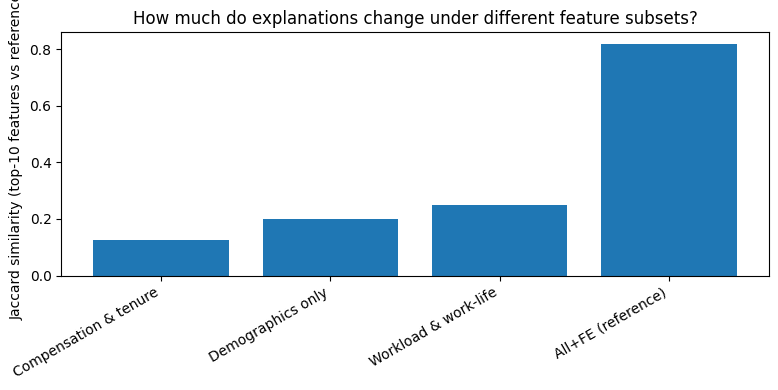

Saved subset comparison results to artifacts/feature_subset_results.csv


In [21]:
plt.figure(figsize=(8, 4))
plt.bar(subset_results["subset"], subset_results["jaccard_top10_vs_reference"])
plt.ylabel("Jaccard similarity (top-10 features vs reference)")
plt.xticks(rotation=30, ha="right")
plt.title("How much do explanations change under different feature subsets?")
plt.tight_layout()
plt.show()

# Save to CSV
subset_results.to_csv("artifacts/feature_subset_results.csv", index=False)
print("Saved subset comparison results to artifacts/feature_subset_results.csv")


## 8) Reporting — HR-friendly insights and recommendations

This notebook generates the key artifacts you would reference in a written report:
- EDA tables/plots to identify high-attrition groups.
- Model metrics (with PR AUC emphasized for imbalance).
- LIME explanations for individuals (including explanations for mistakes).
- Aggregated LIME drivers across high-risk employees.
- A feature-subset experiment to discuss explanation stability.

So, using this report, we can focus on turning the outputs into **actionable** HR hypotheses and interventions (e.g., overtime policies, role-specific retention efforts), while noting limitations (correlation vs causation, data drif, fairness considerations).


In [22]:
print("Best overall model:", best_model_name)
print("\n Top aggregated LIME drivers (by mean_abs_weight)")
display(agg_df.sort_values("mean_abs_weight", ascending=False).head(10))

print("\n Feature subset comparison results")
display(subset_results)

Best overall model: xgboost

 Top aggregated LIME drivers (by mean_abs_weight)


,feature,count,mean_weight,mean_abs_weight,pct_push_leave
0,OverTime ≠ No,16,0.131428,0.131428,1.0
1,0.00 < cat__OverTime_No <= 1.00,9,-0.129890,0.129890,0.0
2,NumCompaniesWorked is high,8,0.116325,0.116325,1.0
3,JobInvolvement is low,14,0.115526,0.115526,1.0
4,EnvironmentSatisfaction is low,11,0.097919,0.097919,1.0
5,StockOptionLevel is low,20,0.095118,0.095118,1.0
6,MonthlyIncome is low,15,0.086970,0.086970,1.0
7,WorkLifeBalance is low,5,0.085906,0.085906,1.0
8,-1.05 < num__JobInvolvement <= 0.37,10,-0.083376,0.083376,0.0
9,DistanceFromHome is high,7,0.076633,0.076633,1.0



 Feature subset comparison results


,subset,trained_model,pred_prob_leave_same_employee,jaccard_top10_vs_reference,accuracy,precision,recall,f1,roc_auc,pr_auc
3,Compensation & tenure,xgboost,0.712064,0.125000,0.823129,0.307692,0.085106,0.133333,0.653372,0.237706
1,Demographics only,xgboost,0.563151,0.200000,0.833333,0.428571,0.127660,0.196721,0.649927,0.321163
2,Workload & work-life,xgboost,0.958658,0.250000,0.853741,0.600000,0.255319,0.358209,0.748988,0.428904
0,All+FE (reference),xgboost,0.986189,0.818182,0.857143,0.692308,0.191489,0.300000,0.791024,0.514076
